In [94]:
# Imports
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
from yfinance import ticker
import json
from io import StringIO
import re
from rapidfuzz import process, fuzz
from joblib import Parallel, delayed
import matplotlib.pyplot as plt 
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

In [14]:

h1b_2009_path = 'data/visas/h1b_2016_2009.csv'
h1b_2017_path = 'data/visas/h1b_2024_2017.csv'

#Had to convert all encoding to UTF8 via notepad++
def read_tsv(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return pd.read_csv(StringIO(f.read()), delimiter="\t", low_memory=False)

# Read all files using the function
df_h1b_a = read_tsv(h1b_2009_path)
df_h1b_b = read_tsv(h1b_2017_path)

In [16]:
df_h1b = pd.concat([df_h1b_a, df_h1b_b], axis=0)

In [21]:
def remove_meta_characters(input_string):
    input_string = str(input_string)
    input_string = re.sub(r'\s+', ' ', input_string).strip() 
    input_string = re.sub(r'\b(INCORPORATED|INC|CORPORATION|CORP|NA|N A|LTD|LIMITED|LLC|LLP|PLC|GROUP|GRP|GR|HOLDINGS|COMPANY|CO|LP|PARTNERSHIP)\b',
                          '', str(input_string).upper())
    input_string = re.sub(r'/[^/]+/', ' ', input_string)
    input_string = input_string.replace('.', '').replace(',', '').replace('&', 'AND')
    input_string = re.sub(r'\s+', ' ', input_string).strip() 
    return input_string

In [27]:
df_h1b['employer'] = df_h1b['Employer (Petitioner) Name'].str.upper().apply(remove_meta_characters)


In [52]:
df_h1b.tail()

,Line by line,Fiscal Year,Employer (Petitioner) Name,Tax ID,Industry (NAICS) Code,Petitioner City,Petitioner State,Petitioner Zip Code,Initial Approval,Initial Denial,Continuing Approval,Continuing Denial,employer
293612,"293,613",2020,ZYWIE INC,9321.0,"54 - Professional, Scientific, and Technical S...",DULUTH,GA,30097.0,0,0,1,0,ZYWIE
293613,"293,614",2020,ZYXEL COMMUNICATIONS INC,160.0,31-33 - Manufacturing,ANAHEIM,CA,92806.0,0,0,1,0,ZYXEL COMMUNICATIONS
293614,"293,615",2020,ZYZYX INC,8307.0,"54 - Professional, Scientific, and Technical S...",MILPITAS,CA,95035.0,0,0,2,0,ZYZYX
293615,"293,616",2020,ZZOUNDS MUSIC LLC,7798.0,44-45 - Retail Trade,CHICAGO,IL,60654.0,0,0,1,0,ZZOUNDS MUSIC
293616,"293,617",2020,ZZZS INC,7355.0,44-45 - Retail Trade,SAN FRANCISCO,CA,94129.0,0,0,1,0,ZZZS


In [88]:
us_cities = pd.read_csv('data/simplemaps_uscities_basicv1.90/uscities.csv')

In [137]:
# Create a long-form ZIP code DataFrame
zip_rows = []

for _, row in us_cities.iterrows():
    if pd.notnull(row["zips"]):
        for zip_code in str(row["zips"]).split():
            zip_rows.append({
                "zip": zip_code.zfill(5),
                "city": row["city"],
                "state_id": row["state_id"],
                "lat": row["lat"],
                "lng": row["lng"],
                "geometry": row["geometry"]
            })

us_zips_expanded = pd.DataFrame(zip_rows)


In [150]:
us_zips_expanded.head()

,zip,city,state_id,lat,lng,geometry
0,11229,new york,NY,40.6943,-73.9249,POINT (-73.9249 40.6943)
1,11226,new york,NY,40.6943,-73.9249,POINT (-73.9249 40.6943)
2,11225,new york,NY,40.6943,-73.9249,POINT (-73.9249 40.6943)
3,11224,new york,NY,40.6943,-73.9249,POINT (-73.9249 40.6943)
4,11223,new york,NY,40.6943,-73.9249,POINT (-73.9249 40.6943)


In [146]:
df_h1b["Petitioner Zip Code"] = (
    df_h1b["Petitioner Zip Code"]
    .astype(str)
    .str.split('.').str[0]
    .str.zfill(5)
)

In [152]:
df_h1b.head()

,Line by line,Fiscal Year,Employer (Petitioner) Name,Tax ID,Industry (NAICS) Code,Petitioner City,Petitioner State,Petitioner Zip Code,Initial Approval,Initial Denial,Continuing Approval,Continuing Denial,employer
0,1,2016,NaN,835.0,52 - Finance and Insurance,northfield,IL,60093,0,0,1,0,NAN
1,2,2016,NaN,1416.0,92 - Public Administration,flushing,NY,11355,0,0,0,1,NAN
2,3,2016,NaN,2773.0,61 - Educational Services,saratoga,CA,95070,0,0,0,1,NAN
3,4,2016,NaN,3744.0,81 - Other Services (except Public Administrat...,export,PA,15632,0,0,1,0,NAN
4,5,2016,NaN,3799.0,NaN,irvine,CA,92612,0,1,0,0,NAN


In [154]:
merged = pd.merge(left = us_zips_expanded, right = df_h1b, 
                  left_on = 'zip', right_on = 'Petitioner Zip Code',
                  how = 'outer', indicator = True)

In [164]:
right = merged[merged['_merge'] == 'right_only']

In [186]:
both = merged[merged['_merge'] == 'both']

In [190]:
both["geometry"] = both.apply(lambda row: Point(row["lng"], row["lat"]), axis=1)
gdf = gpd.GeoDataFrame(both, geometry="geometry", crs="EPSG:4326")

/var/folders/rg/q8grhvf93ddfx_8k_xv69z_h0000gn/T/ipykernel_90435/4121606610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both["geometry"] = both.apply(lambda row: Point(row["lng"], row["lat"]), axis=1)


In [191]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [201]:
gdf.head()

,zip,city,state_id,lat,lng,geometry,Line by line,Fiscal Year,Employer (Petitioner) Name,Tax ID,Industry (NAICS) Code,Petitioner City,Petitioner State,Petitioner Zip Code,Initial Approval,Initial Denial,Continuing Approval,Continuing Denial,employer,_merge
5,00603,aguadilla,PR,18.4382,-67.1537,POINT (-67.1537 18.4382),"23,358",2024.0,GRUPO ORICTEROPO TROPICAL LLC,3211.0,"54 - Professional, Scientific, and Technical S...",aguadilla,PR,00603,1,0,0,0,GRUPO ORICTEROPO TROPICAL,both
9,00605,aguadilla,PR,18.4382,-67.1537,POINT (-67.1537 18.4382),"64,764",2015.0,CESAR SANTIAGO GROUP INC,9665.0,"71 - Arts, Entertainment, and Recreation",aguadilla,PR,00605,0,0,1,0,CESAR SANTIAGO,both
10,00605,aguadilla,PR,18.4382,-67.1537,POINT (-67.1537 18.4382),"301,728",2011.0,CESAR SANTIAGO ENTERTAINMENT CORP,9665.0,NaN,aguadilla,PR,00605,0,0,1,0,CESAR SANTIAGO ENTERTAINMENT,both
11,00605,aguadilla,PR,18.4382,-67.1537,POINT (-67.1537 18.4382),"56,599",2024.0,UNIVERSIDAD DE PUERTO RICO EN AGUADILLA,807.0,61 - Educational Services,aguadilla,PR,00605,1,0,0,0,UNIVERSIDAD DE PUERTO RICO EN AGUADILLA,both
13,00610,añasco,PR,18.2861,-67.1409,POINT (-67.1409 18.2861),"10,597",2024.0,CENTRO DE CUIDADO DIURNO HABACUC,761.0,61 - Educational Services,anasco,PR,00610,1,0,0,0,CENTRO DE CUIDADO DIURNO HABACUC,both


In [197]:
gdf = gdf.drop_duplicates(subset = 'Employer (Petitioner) Name')

In [213]:
# List of valid U.S. states + DC
valid_states = [
    'MA', 'RI', 'NH', 'ME', 'VT', 'CT', 'NY', 'NJ', 'PA', 'DE', 'DC', 'VA', 'MD', 'WV',
    'NC', 'SC', 'GA', 'FL', 'AL', 'TN', 'MS', 'KY', 'OH', 'IN', 'MI', 'IA', 'WI', 'MN',
    'SD', 'ND', 'MT', 'IL', 'MO', 'KS', 'NE', 'LA', 'AR', 'OK', 'TX', 'CO', 'WY', 'ID',
    'UT', 'AZ', 'NM', 'NV', 'CA', 'OR', 'WA',
]

# Filter to only valid states
filtered = gdf[gdf['Petitioner State'].isin(valid_states)]


In [284]:
usa = geopandas.read_file('data/cb_2021_us_state_20m.zip')

In [286]:
type(usa)

geopandas.geodataframe.GeoDataFrame

In [288]:
top_20_employers = (
    filtered.groupby("employer")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .reset_index(name="count")
)

In [290]:
top_20_gdf = filtered[filtered["employer"].isin(top_20_employers["employer"])]

top_20_gdf = gpd.GeoDataFrame(top_20_gdf, geometry="geometry", crs="EPSG:4326")


In [292]:
type(top_20_gdf)

geopandas.geodataframe.GeoDataFrame

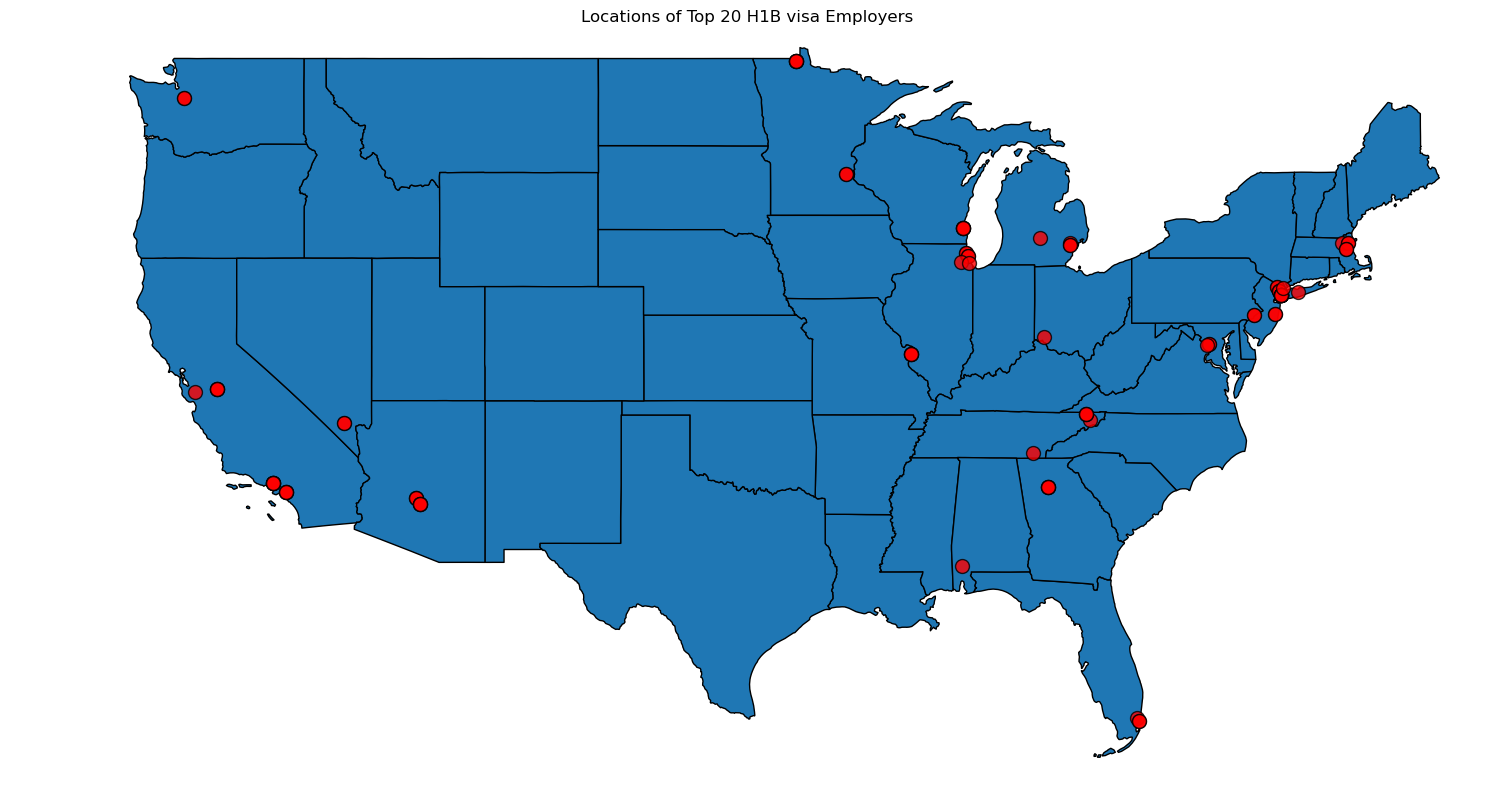

In [306]:
fig, gax = plt.subplots(figsize = (20, 10))

usa.plot(ax=gax, edgecolor = 'black')
top_20_gdf.plot(ax=gax, color = 'red', edgecolor = 'black', markersize=100, alpha=0.8)

gax.set_xlim(-130, -65)
gax.set_ylim(23, 50)

gax.set_title('Locations of Top 20 H1B visa Employers')

gax.axis('off')

plt.show()

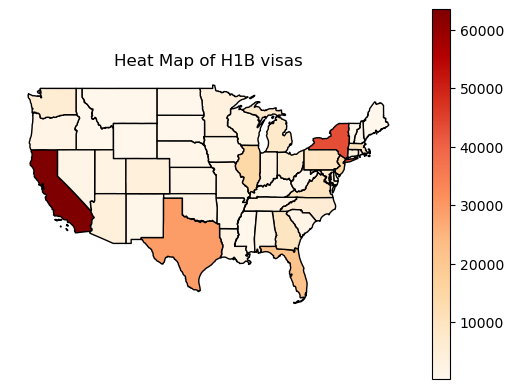

In [320]:
by_state = filtered.groupby("Petitioner State").size().reset_index(name="count")

choropleth = usa.merge(by_state, left_on="STUSPS", right_on="Petitioner State", how="left")
choropleth.plot(column="count", cmap="OrRd", legend=True, edgecolor = 'black')

plt.axis('off')

plt.title('Heat Map of H1B visas')

plt.show()